# EFCamDat 5 Class BERT & RoBERTa (CNN+LSTM / CNN+GRU) Models

## Download and augment data

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import random
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet

# Download the WordNet corpus
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package wordnet to C:\Users\Danny
[nltk_data]     Skahill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Danny
[nltk_data]     Skahill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel

In [4]:
max_length = 85
MAX_SEQUENCE_LENGTH = 85
BATCH_SIZE = 32

In [5]:
df = pd.read_csv("..//efcamdat_sub.csv")

In [6]:
df['labels'] = df['cefr_numeric'].apply(lambda x: x-1)

In [7]:
text = df['text']
labels = df['labels']

In [8]:
train_df, test_df = train_test_split(df, test_size=.1, shuffle=True)

In [9]:
len(train_df)

340170

In [10]:
valid_df = train_df.iloc[:34000].copy()
train_df = train_df.iloc[34000:]
test_df = test_df.iloc[:1000]

In [11]:
def clip_words(text, num_words=5):
    text = str(text)
    words = text.split()
    if len(words) > 2 * num_words:
        return ' '.join(words[num_words:-num_words])
    else:
        # If the text has fewer than 2 * num_words, return an empty string or handle accordingly
        return text

In [12]:
train_df['text_clipped'] = train_df['text'].apply(clip_words)

In [13]:
train_df['text_clipped'] = train_df['text_clipped'].apply(lambda x: str(x))

In [14]:
def synonym_replacement(text):
    words = text.split()
    new_words = []
    
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym if synonym != word else word)
        else:
            new_words.append(word)
    
    return ' '.join(new_words)

def random_insertion(text):
    words = text.split()
    new_words = words.copy()
    synonyms = [wordnet.synsets(word)[0].lemmas()[0].name() for word in words if wordnet.synsets(word)]
    
    num_insertions = random.randint(1, 3)
    for _ in range(num_insertions):
        insert_word = random.choice(synonyms) if synonyms else random.choice(words)
        position = random.randint(0, len(new_words))
        new_words.insert(position, insert_word)
    
    return ' '.join(new_words)

def random_deletion(text, p=0.2):
    words = text.split()
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else words[0]

def sentence_shuffling(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return text
    random.shuffle(sentences)
    return ' '.join(sentences)

def augment(text):
    if random.random() > .4:
        return text
    else:
        if random.random() < .5:
            text = synonym_replacement(text)
        if random.random() < .5: 
            text = random_insertion(text)
        if random.random() < .5:
            text = random_deletion(text, p=0.2)
        if random.random() < .5: 
            text = sentence_shuffling(text)
        return text 


In [15]:
tqdm.pandas()
train_df['text_clipped'] = train_df['text_clipped'].progress_apply(lambda x: augment(x))

100%|████████████████████████████████████████████████████████████████████████| 306170/306170 [02:47<00:00, 1832.94it/s]


In [16]:
train_df.to_csv('../efcamdat_train_data.csv')
valid_df.to_csv('../efcamdat_valid_data.csv')
test_df.to_csv('../efcamdat_test_data.csv')

## BERT

In [17]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

#tokenize text data for each split
train_encodings = bert_tokenizer(train_df["text_clipped"].tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
valid_encodings = bert_tokenizer([str(t) for t in valid_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer([str(t) for t in test_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'token_type_ids': encodings['token_type_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    return dataset

#create TF datasest with encoding and labels
train_dataset = create_dataset(train_encodings, train_df['labels'])
valid_dataset = create_dataset(valid_encodings, valid_df['labels'])
test_dataset = create_dataset(test_encodings, test_df['labels'])

#batching
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [18]:
def create_bert_classification_model(bert_model, num_classes=6, num_train_layers=0, hidden_size=200, dropout=0.5, learning_rate=0.00005):
    if num_train_layers == 0:
        bert_model.trainable = False
    elif num_train_layers == 12:
        bert_model.trainable = True
    else:
        retrain_layers = ['_' + str(11 - i) for i in range(num_train_layers)]
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    bert_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)
    pooler_token = bert_out[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

### Untrainable

In [19]:
bert_classification_model_ut = create_bert_classification_model(bert_model, num_train_layers=0)

In [20]:
bert_classification_model_ut_history = bert_classification_model_ut.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=3,
)

Epoch 1/3
9568/9568 [==============================] - 1041s 107ms/step - loss: 1.2569 - accuracy: 0.4710 - val_loss: 1.0906 - val_accuracy: 0.5644
Epoch 2/3
9568/9568 [==============================] - 1064s 111ms/step - loss: 1.1085 - accuracy: 0.5455 - val_loss: 1.0530 - val_accuracy: 0.5695
Epoch 3/3
9568/9568 [==============================] - 1031s 108ms/step - loss: 1.0681 - accuracy: 0.5662 - val_loss: 1.0017 - val_accuracy: 0.6021


In [21]:
preds = bert_classification_model_ut.predict(test_dataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

32/32 [==============================] - 6s 91ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       291
           1       0.57      0.52      0.55       268
           2       0.52      0.74      0.61       256
           3       0.55      0.47      0.51       145
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00         9

    accuracy                           0.60      1000
   macro avg       0.40      0.41      0.40      1000
weighted avg       0.59      0.60      0.59      1000



C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [22]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

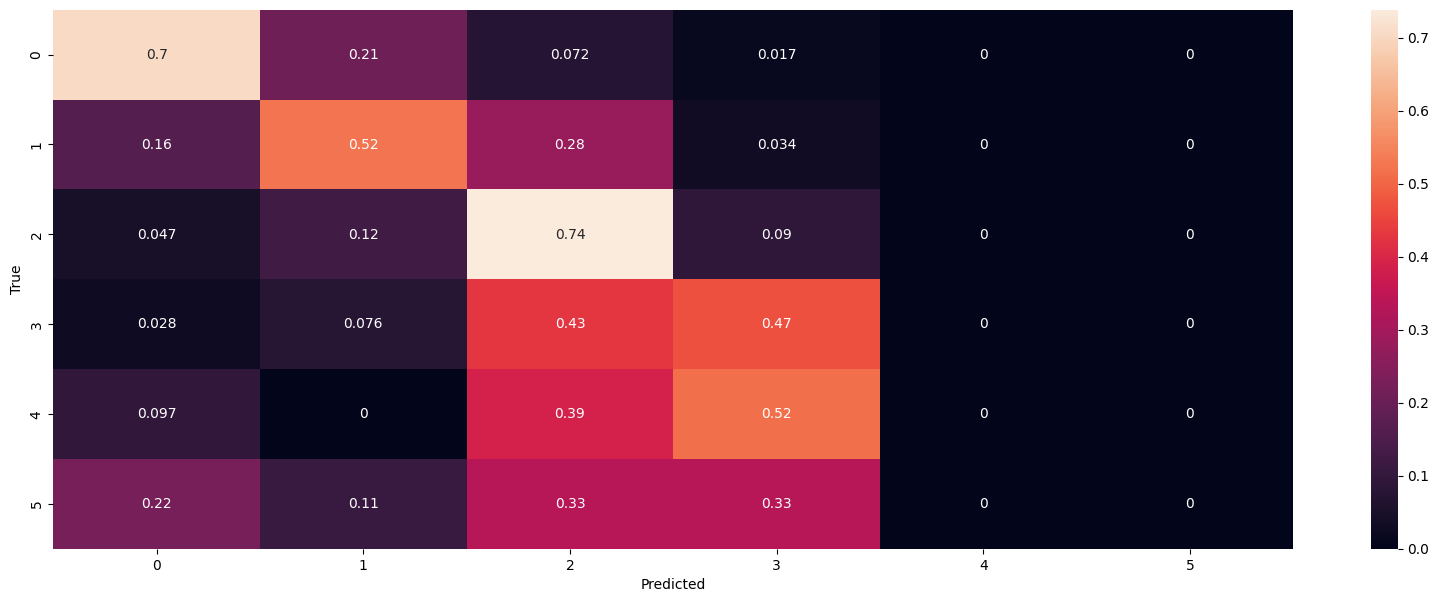

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

### Trainable

In [19]:
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [20]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 85)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

In [21]:
bert_classification_model_history = bert_classification_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1,
)

9568/9568 [==============================] - 2230s 232ms/step - loss: 0.2427 - accuracy: 0.9188 - val_loss: 0.1372 - val_accuracy: 0.9569


In [22]:
preds = bert_classification_model.predict(test_dataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

32/32 [==============================] - 6s 85ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       291
           1       0.94      0.97      0.96       268
           2       0.94      0.98      0.96       256
           3       0.96      0.93      0.94       145
           4       0.93      0.84      0.88        31
           5       1.00      0.67      0.80         9

    accuracy                           0.96      1000
   macro avg       0.96      0.89      0.92      1000
weighted avg       0.96      0.96      0.96      1000



In [23]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

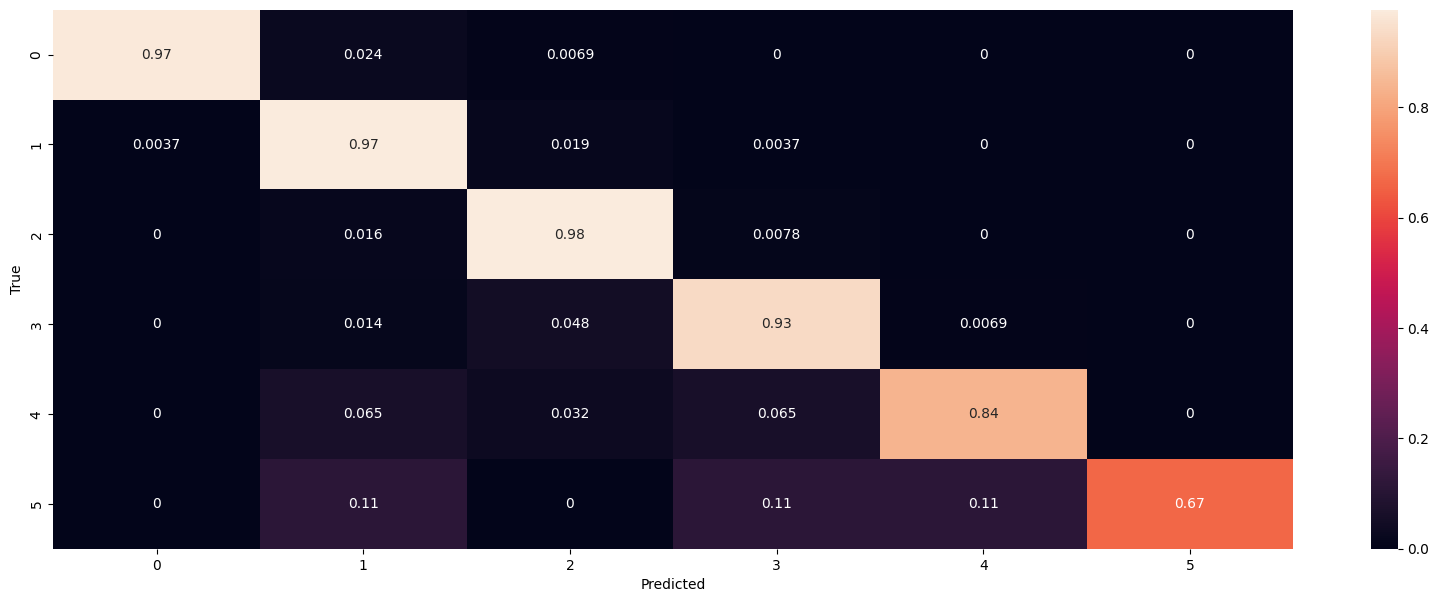

In [24]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

## RoBERTa

In [25]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

train_encodings = rtokenizer(train_df["text_clipped"].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = rtokenizer([str(t) for t in valid_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_df['labels']))
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_df['labels']))
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [26]:
def create_roberta_cl_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    #tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)
    # dense = tf.keras.layers.Dense(256, activation='relu')(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [27]:
roberta_cl_model = create_roberta_cl_model(model=roberta_model, num_classes=6)

In [28]:
roberta_cl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                         

In [29]:
roberta_cl_model_history = roberta_cl_model.fit(train_dataset,
                                      validation_data=valid_dataset,
                                      epochs=5)

Epoch 1/5
9568/9568 [==============================] - 1097s 113ms/step - loss: 0.4593 - accuracy: 0.8360 - val_loss: 0.2334 - val_accuracy: 0.9213
Epoch 2/5
9568/9568 [==============================] - 1101s 115ms/step - loss: 0.2723 - accuracy: 0.9056 - val_loss: 0.1780 - val_accuracy: 0.9395
Epoch 3/5
9568/9568 [==============================] - 1133s 118ms/step - loss: 0.2243 - accuracy: 0.9235 - val_loss: 0.1562 - val_accuracy: 0.9488
Epoch 4/5
9568/9568 [==============================] - 1110s 116ms/step - loss: 0.1986 - accuracy: 0.9326 - val_loss: 0.1518 - val_accuracy: 0.9498
Epoch 5/5
9568/9568 [==============================] - 1079s 113ms/step - loss: 0.1810 - accuracy: 0.9390 - val_loss: 0.1374 - val_accuracy: 0.9552


In [30]:
test_encodings = rtokenizer([str(t) for t in test_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_df['labels']))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
preds = roberta_cl_model.predict(tdataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

32/32 [==============================] - 6s 87ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       291
           1       0.97      0.95      0.96       268
           2       0.94      0.96      0.95       256
           3       0.93      0.94      0.94       145
           4       0.90      0.90      0.90        31
           5       0.83      0.56      0.67         9

    accuracy                           0.96      1000
   macro avg       0.93      0.88      0.90      1000
weighted avg       0.96      0.96      0.96      1000



In [32]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

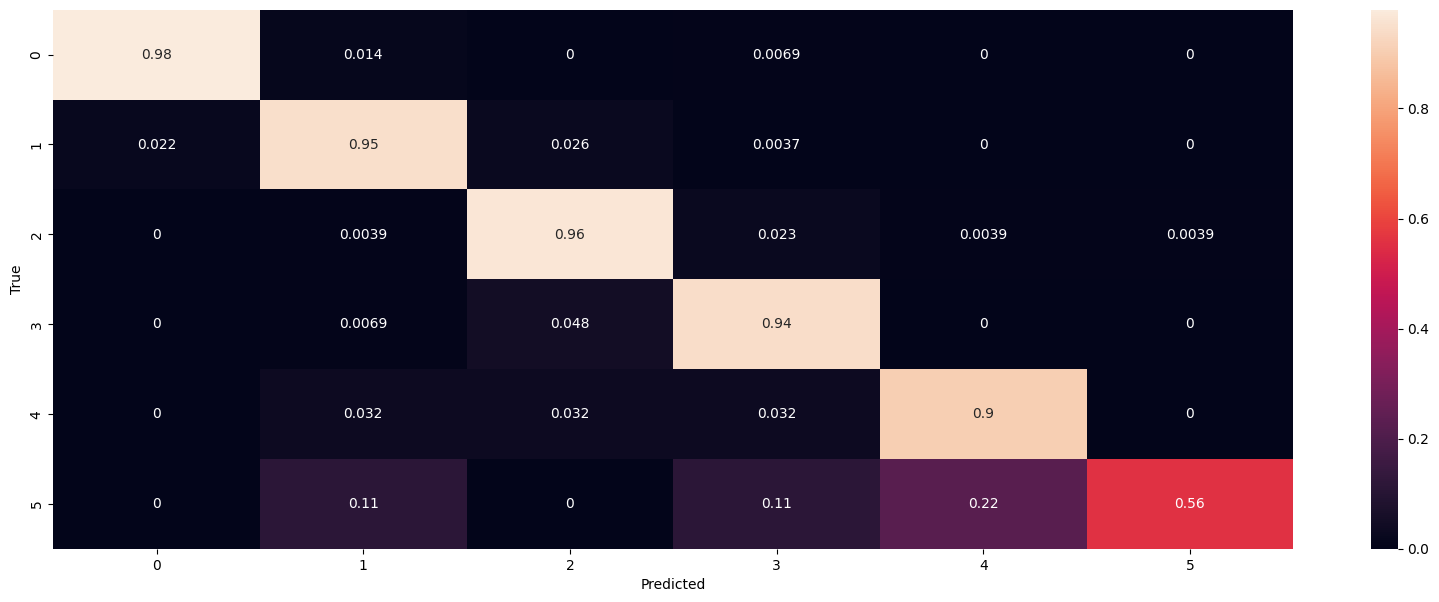

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

## RoBERTa + CNN + GRU

In [34]:
def create_roberta_gru_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    gru = tf.keras.layers.GRU(256)(conv)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(gru)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [35]:
roberta_gru_model = create_roberta_gru_model(model=roberta_model, num_classes=6)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [36]:
roberta_gru_model_history = roberta_gru_model.fit(train_dataset,
                                      validation_data=valid_dataset,
                                      epochs=3)

Epoch 1/3
9568/9568 [==============================] - 1097s 113ms/step - loss: 0.4699 - accuracy: 0.8308 - val_loss: 0.2338 - val_accuracy: 0.9218
Epoch 2/3
9568/9568 [==============================] - 1082s 113ms/step - loss: 0.2670 - accuracy: 0.9073 - val_loss: 0.1665 - val_accuracy: 0.9431
Epoch 3/3
9568/9568 [==============================] - 1077s 113ms/step - loss: 0.2145 - accuracy: 0.9260 - val_loss: 0.1450 - val_accuracy: 0.9516


In [37]:
preds = roberta_gru_model.predict(tdataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

32/32 [==============================] - 6s 87ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       291
           1       0.98      0.94      0.96       268
           2       0.92      0.96      0.94       256
           3       0.86      0.92      0.89       145
           4       0.90      0.84      0.87        31
           5       1.00      0.22      0.36         9

    accuracy                           0.94      1000
   macro avg       0.94      0.81      0.83      1000
weighted avg       0.95      0.94      0.94      1000



Text(220.72222222222223, 0.5, 'True')

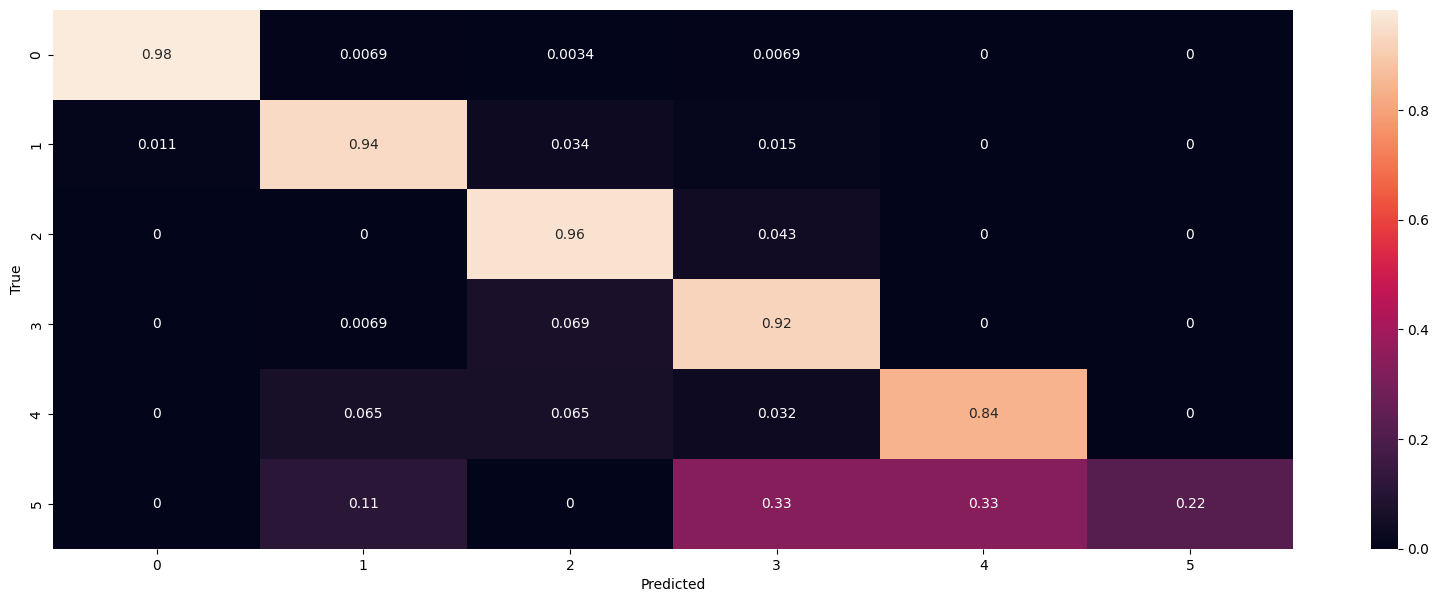

In [38]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")